# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

4.044808961792358 -0.7853221438069
4.04880976195239 -0.7877926968324835
4.052810562112422 -0.7902506401483512
4.056811362272454 -0.7926959344117269
4.060812162432486 -0.7951285404823001
4.0648129625925185 -0.797548419422852
4.0688137627525505 -0.7999555324998797
4.0728145629125825 -0.8023498411842149
4.0768153630726145 -0.8047313071516419
4.0808161632326465 -0.8070998922835098
4.0848169633926785 -0.8094555586673438
4.0888177635527105 -0.8117982685974511
4.0928185637127426 -0.814127984575525
4.096819363872775 -0.8164446693112452
4.100820164032807 -0.8187482857228738
4.104820964192839 -0.8210387969378501
4.108821764352871 -0.8233161662933797
4.112822564512903 -0.8255803573370222
4.116823364672935 -0.8278313338272738
4.120824164832967 -0.8300690597341484
4.124824964992999 -0.8322934992397534
4.128825765153031 -0.8345046167388634
4.132826565313063 -0.8367023768394906
4.136827365473095 -0.83888674436345
4.140828165633127 -0.841057684346924
4.144828965793159 -0.8432151620410208
4.14882976595

7.869573914782957 0.9998784428523647
7.873574714942989 0.999808061729445
7.877575515103021 0.9997216772981923
7.881576315263053 0.9996192909413084
7.885577115423085 0.9995009042976286
7.889577915583117 0.9993665192620944
7.893578715743149 0.9992161379857238
7.897579515903181 0.9990497628755769
7.901580316063213 0.9988673965947168
7.905581116223245 0.9986690420621678
7.909581916383277 0.9984547024528679
7.913582716543309 0.9982243811976187
7.917583516703341 0.9979780819830295
7.921584316863373 0.9977158087514595
7.925585117023405 0.9974375657009539
7.929585917183437 0.9971433572851767
7.933586717343469 0.9968331882133398
7.937587517503501 0.9965070634501274
7.941588317663533 0.9961649882156166
7.945589117823565 0.9958069679851939
7.949589917983597 0.9954330084894671
7.953590718143629 0.9950431157141746
7.957591518303661 0.9946372959000881
7.961592318463693 0.9942155555429143
7.965593118623725 0.9937779013931897
7.969593918783756 0.9933243404561733
7.973594718943788 0.992854879991734
7.9

11.854370874174835 -0.6533489934000534
11.858371674334867 -0.6503149393878286
11.862372474494899 -0.6472704761871936
11.866373274654931 -0.6442156525289849
11.870374074814963 -0.6411505173098727
11.874374874974995 -0.6380751195915777
11.878375675135027 -0.6349895086000861
11.88237647529506 -0.6318937337248619
11.886377275455091 -0.6287878445180557
11.890378075615123 -0.6256718906937124
11.894378875775155 -0.6225459221269746
11.898379675935187 -0.6194099888532849
11.90238047609522 -0.6162641410675846
11.906381276255251 -0.6131084291235107
11.910382076415283 -0.6099429035325895
11.914382876575315 -0.6067676149634283
11.918383676735347 -0.6035826142409044
11.92238447689538 -0.6003879523453516
11.926385277055411 -0.5971836804117436
11.930386077215443 -0.5939698497288768
11.934386877375475 -0.5907465117385481
11.938387677535507 -0.587513718034732
11.94238847769554 -0.5842715203627548
11.946389277855571 -0.5810199706184664
11.950390078015603 -0.5777591208474095
11.954390878175635 -0.57448902

15.747149429885978 -0.03917613395394308
15.75115023004601 -0.043173538583180376
15.755151030206042 -0.04717025216032855
15.759151830366074 -0.05116621071246906
15.763152630526106 -0.05516135027876857
15.767153430686138 -0.05915560691150276
15.77115423084617 -0.06314891667707986
15.775155031006202 -0.06714121565706405
15.779155831166234 -0.07113243994919849
15.783156631326266 -0.07512252566842821
15.787157431486298 -0.0791114089479227
15.79115823164633 -0.08309902594009815
15.795159031806362 -0.08708531281763937
15.799159831966394 -0.09107020577452157
15.803160632126426 -0.09505364102703155
15.807161432286458 -0.09903555481478868
15.81116223244649 -0.10301588340176546
15.815163032606522 -0.10699456307730776
15.819163832766554 -0.1109715301571545
15.823164632926586 -0.1149467209844571
15.827165433086618 -0.11892007193079833
15.83116623324665 -0.12289151939721081
15.835167033406682 -0.126860999815195
15.839167833566714 -0.13082844964773663
15.843168633726746 -0.1347938053903238
15.8471694

0.7488885134032939
19.6999399879976 0.7515338271142193
19.70394078815763 0.7541671114886969
19.707941588317663 0.7567883243773743
19.711942388477695 0.7593974238241208
19.715943188637727 0.7619943680666976
19.71994398879776 0.7645791155374269
19.72394478895779 0.7671516248638568
19.727945589117823 0.7697118548694243
19.731946389277855 0.7722597645741133
19.735947189437887 0.7747953131951116
19.73994798959792 0.777318460147463
19.74394878975795 0.779829165044717
19.747949589917983 0.7823273876995757
19.751950390078015 0.7848130881245364
19.755951190238047 0.7872862265325322
19.75995199039808 0.7897467633375685
19.76395279055811 0.7921946591553569
19.767953590718143 0.7946298748039452
19.771954390878175 0.7970523713043449
19.775955191038207 0.7994621098811553
19.77995599119824 0.8018590519631835
19.78395679135827 0.8042431591840624
19.787957591518303 0.8066143933828646
19.791958391678335 0.8089727166047128
19.795959191838367 0.8113180911013882
19.7999599919984 0.8136504793319341
19.80396

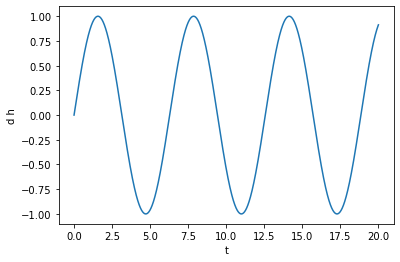

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

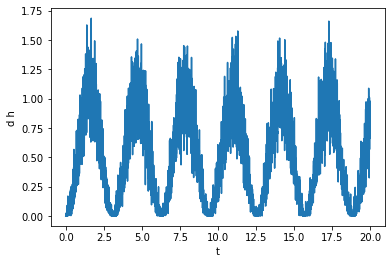

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

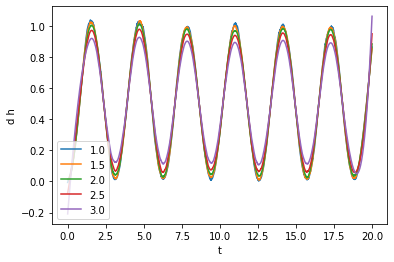

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

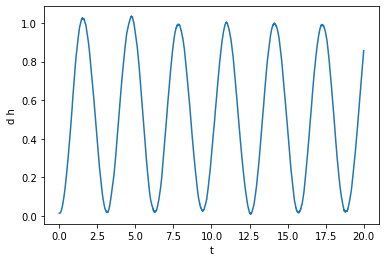

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.2084


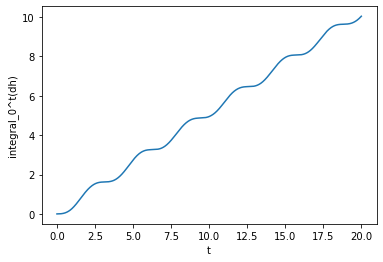

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

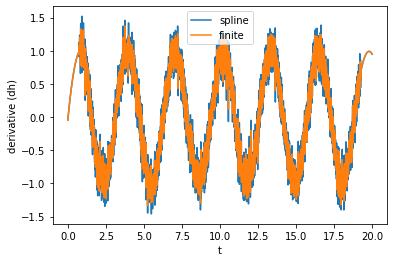

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

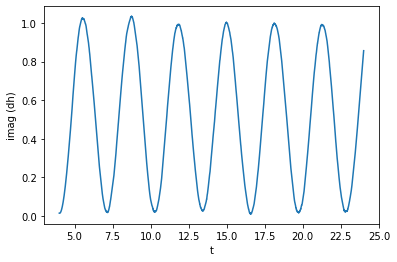

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

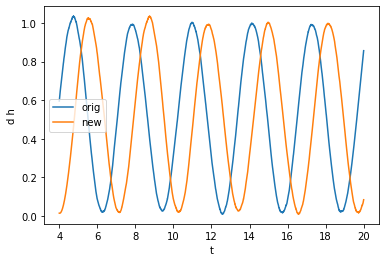

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

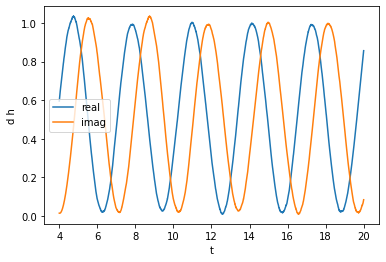

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

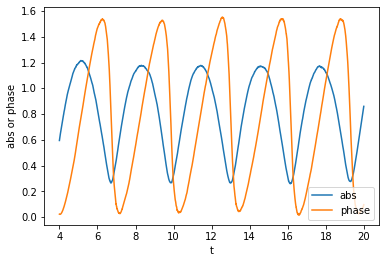

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

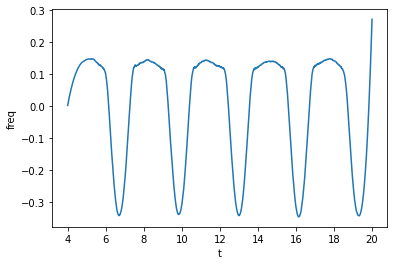

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

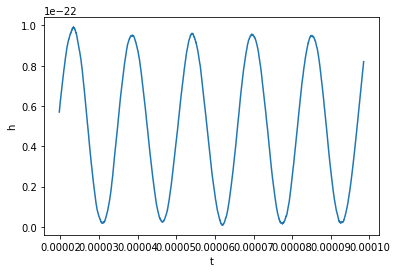

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

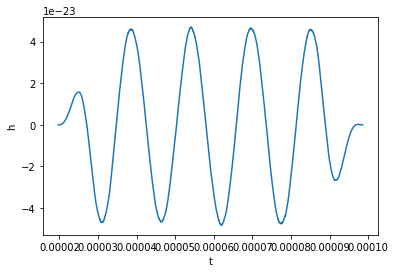

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

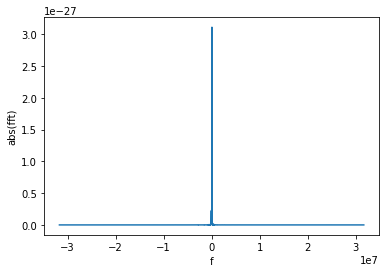

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

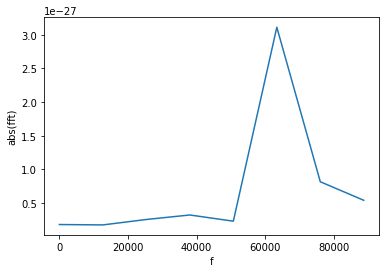

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64149.63


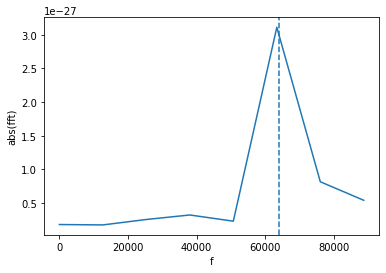

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.111e-27
Maximum with mask 8.163e-28
Length with mask 8
Length after having removed the masked points 7
